# Advanced Lane Finding

### by Wenzhe Ding

In this project, our goal is to write a software pipeline to identify the lane boundaries in a video. The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Table of contents
- [Camera Calibration](#CameraCalibration)
- [Color Thresholding](#ColorThresholding)
    - [Color Space](#ColorSpace)
- [Gradient Thresholding](#GradientThresholding)
    - [Sobel Operator](#SobelOperator)   
    - [Magnitude of Gradient](#MagnitudeofGradient)  
    - [Direction of Gradient](#DirectionofGradient)  
- [Color and Gradient](#ColorandGradient)
- [Perspective Transform](#Transform)
- [Thresholding & Perspective Transforming](#ThresholdingTransforming)
- [Dealing with Curved Lines](#CurvedLines)
    - [Histogram](#Histogram) 
    - [Fitting a Polynomial](#Polynomial) 
    - [Measuring Curvature](#curvature)  
- [Finalize Detection](#Finalize)
    - [Draw lines](#Draw)  
    - [Add text](#text)  
- [Complete Pipeline](#Complete)
    - [Track Previous Detections](#Previous)  
    - [Process Video](#Video)  
- [Reflection](#Reflection)  


In [1]:
import pickle
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

----
<a id='CameraCalibration'></a>

## Camera Calibration
[[ go back to the top ]](#Table-of-contents)

The first step in our pipeline is to correct distortion on camera images because distortion changes the shape and size of object in the image. In order to calibrate our camera, we map distored points to undistorted points of a chess board. I started by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, object points `objp` is just a replicated array of coordinates, and list of object points `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image. List of image points `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

In [2]:
images = glob.glob('./camera_cal/*.jpg')
print("Number of images: ", len(images))

Number of images:  20


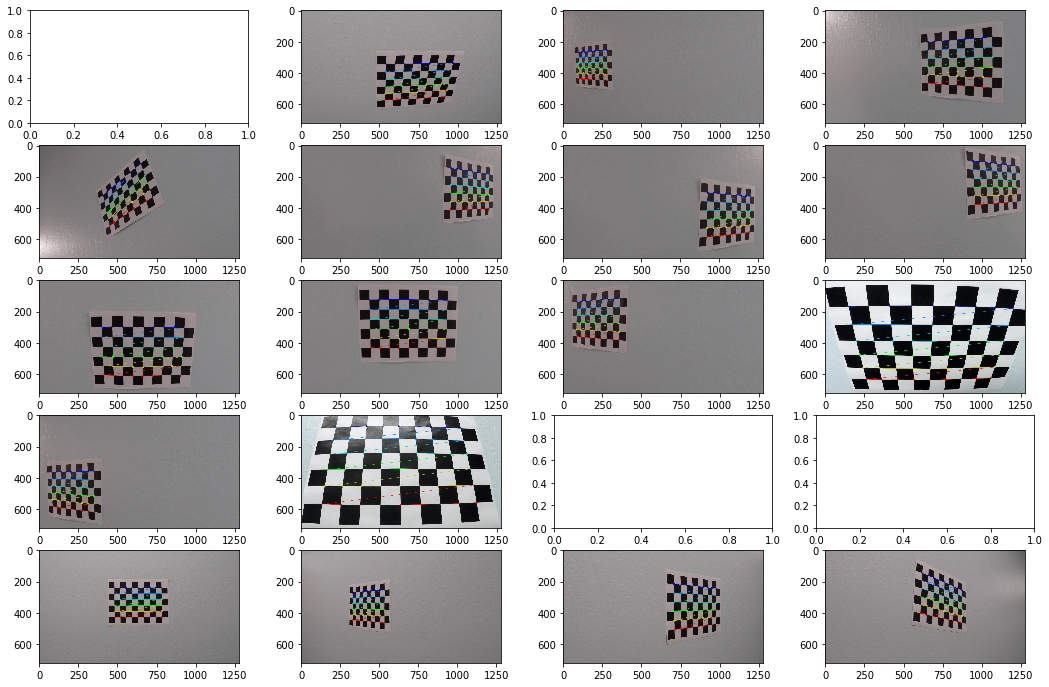

In [3]:
# find corners
identified_img = []
objpoints = []
imgpoints = []

fig, axs = plt.subplots(5,4, figsize=(18, 12))
axs = axs.ravel()
for idx, path in enumerate(images):
    img = cv2.imread(path)
    # prepare object points
    objp = np.zeros((9*6,3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    nx = 9
    ny = 6
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        identified_img.append(img)
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)     
        axs[idx].imshow(img)

Some images' corners can not be found due to that they have different number of corners, i.e.9x5 (see above image) rather than 9x6. I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

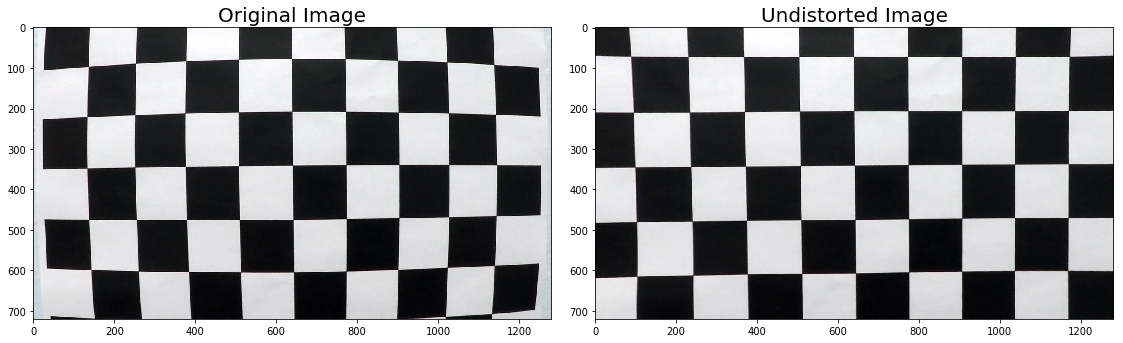

In [4]:
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
    img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist

# use first image as an example
img = cv2.imread(images[0])
undistorted, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

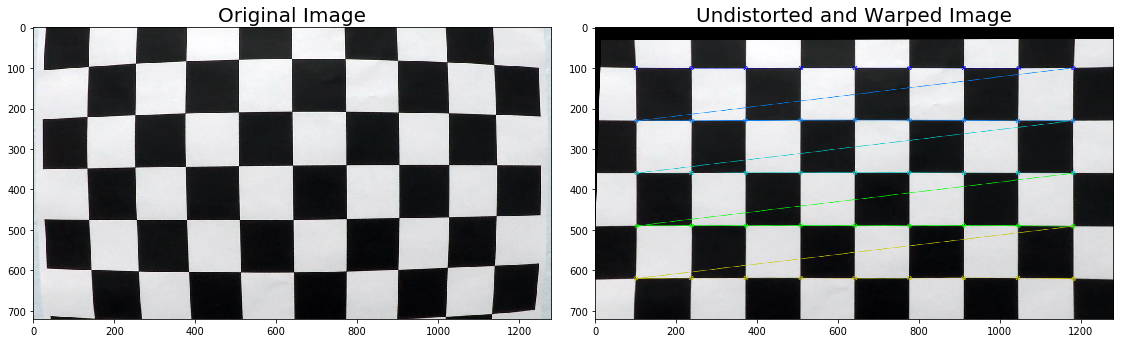

In [5]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M

nx = 9
ny = 5
w, m = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(w)
ax2.set_title('Undistorted and Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In the sections, we'll describe how we used color transforms, gradients as well as other methods to create a thresholded binary image. We will use the above image, which is one of the most challengling image (with large areas of shadows), to demonstrate every steps. Let's apply the distortion correction to one of the test images. It is clear the shape of the car hood has changed after undistortion.

Text(0.5,1,'Undistorted Image')

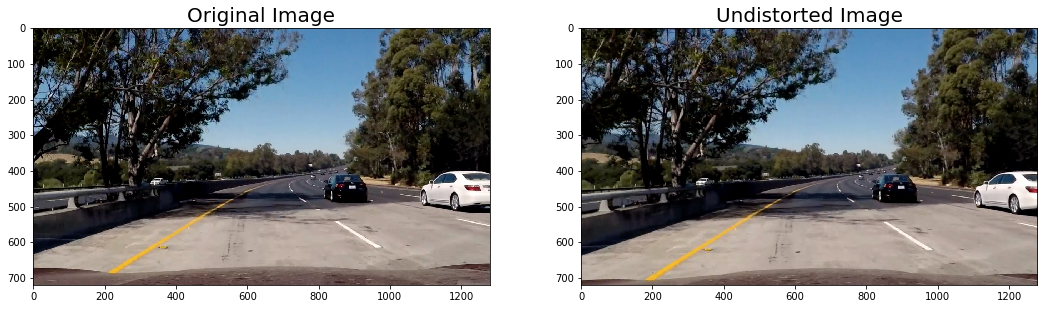

In [9]:
f, (ax1, ax2)  = plt.subplots(1, 2, figsize=(18, 9))
sample_img = mpimg.imread('test_images/test5.jpg')
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)

undist_sample = cv2.undistort(sample_img, mtx, dist, None, mtx)
ax2.imshow(undist_sample)
ax2.set_title('Undistorted Image', fontsize=20)

----
<a id='ColorThresholding'></a>
## Color Thresholding
[[ go back to the top ]](#Table-of-contents)

<a id='ColorSpace'></a>
### Color Space
[[ go back to the top ]](#Table-of-contents)

A color space is a specific organization of colors; color spaces provide a way to categorize colors and represent them in digital images. Let's visualize all possible color space channels for this image.

Text(0.5,1,'HSV V-Channel')

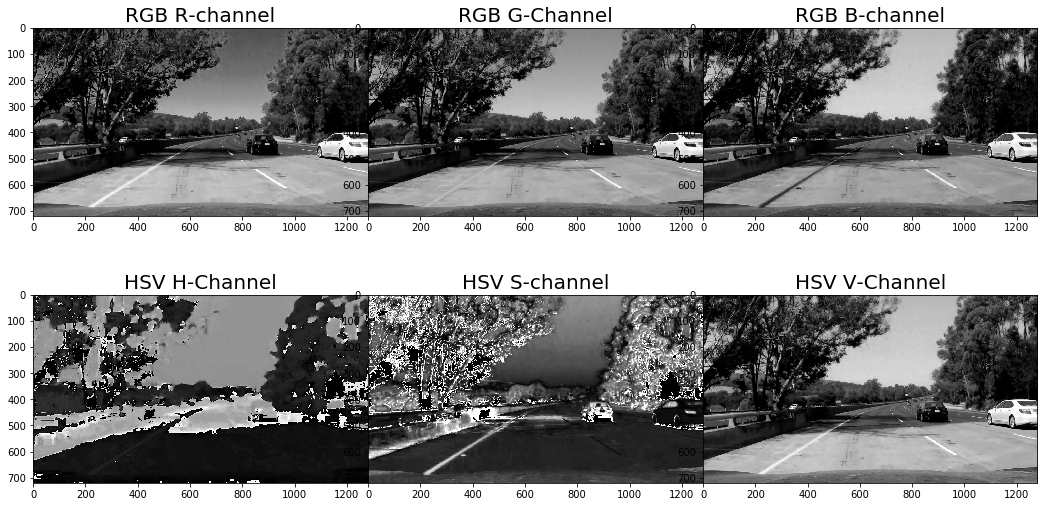

In [10]:
fig, axs = plt.subplots(2,3, figsize=(18, 9))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
sample_R = sample_img[:,:,0]
sample_G = sample_img[:,:,1]
sample_B = sample_img[:,:,2]
sample_H = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HSV)[:,:,0]
sample_S = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HSV)[:,:,1]
sample_V = cv2.cvtColor(sample_img, cv2.COLOR_RGB2HSV)[:,:,2]

axs[0].imshow(sample_R, cmap='gray')
axs[0].set_title('RGB R-channel', fontsize=20)
axs[1].imshow(sample_G, cmap='gray')
axs[1].set_title('RGB G-Channel', fontsize=20)
axs[2].imshow(sample_B, cmap='gray')
axs[2].set_title('RGB B-channel', fontsize=20)
axs[3].imshow(sample_H, cmap='gray')
axs[3].set_title('HSV H-Channel', fontsize=20)
axs[4].imshow(sample_S, cmap='gray')
axs[4].set_title('HSV S-channel', fontsize=20)
axs[5].imshow(sample_V, cmap='gray')
axs[5].set_title('HSV V-Channel', fontsize=20)

I used a combination of color and gradient thresholds to generate a binary image. Here are examples of applying thresholding on some color spaces to produce thresholded binary images. 

In [11]:
def get_binary(img, conv_type="gray", thresh = (180, 255)):
    if conv_type == "gray":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if conv_type == "R":
        img = img[:,:,0]
    if conv_type == "G":
        img = img[:,:,1]
    if conv_type == "B":
        img = img[:,:,2]
    if conv_type == "H":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img = img[:,:,0]
    if conv_type == "S":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img = img[:,:,1]
    if conv_type == "V":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        img = img[:,:,2]
    if conv_type == "HLS_H":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = img[:,:,0]
    if conv_type == "HLS_L":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = img[:,:,1]
    if conv_type == "HLS_S":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = img[:,:,2]
    if conv_type == "LAB_L":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = img[:,:,0]
    if conv_type == "LAB_A":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = img[:,:,1]
    if conv_type == "LAB_B":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = img[:,:,2]
    if conv_type == "LUV_L":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
        img = img[:,:,0]
    if conv_type == "LUV_U":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
        img = img[:,:,1]
    if conv_type == "LUV_V":
        img = cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
        img = img[:,:,2]
    binary = np.zeros_like(img)
    binary[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary

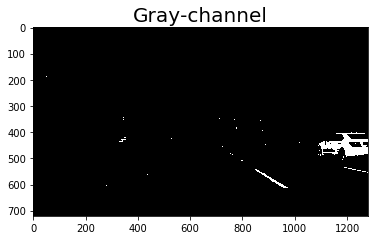

In [9]:
plt.imshow(get_binary(sample_img, conv_type="gray", thresh = (200, 255)), cmap="gray")
plt.title("Gray-channel", fontsize=20)

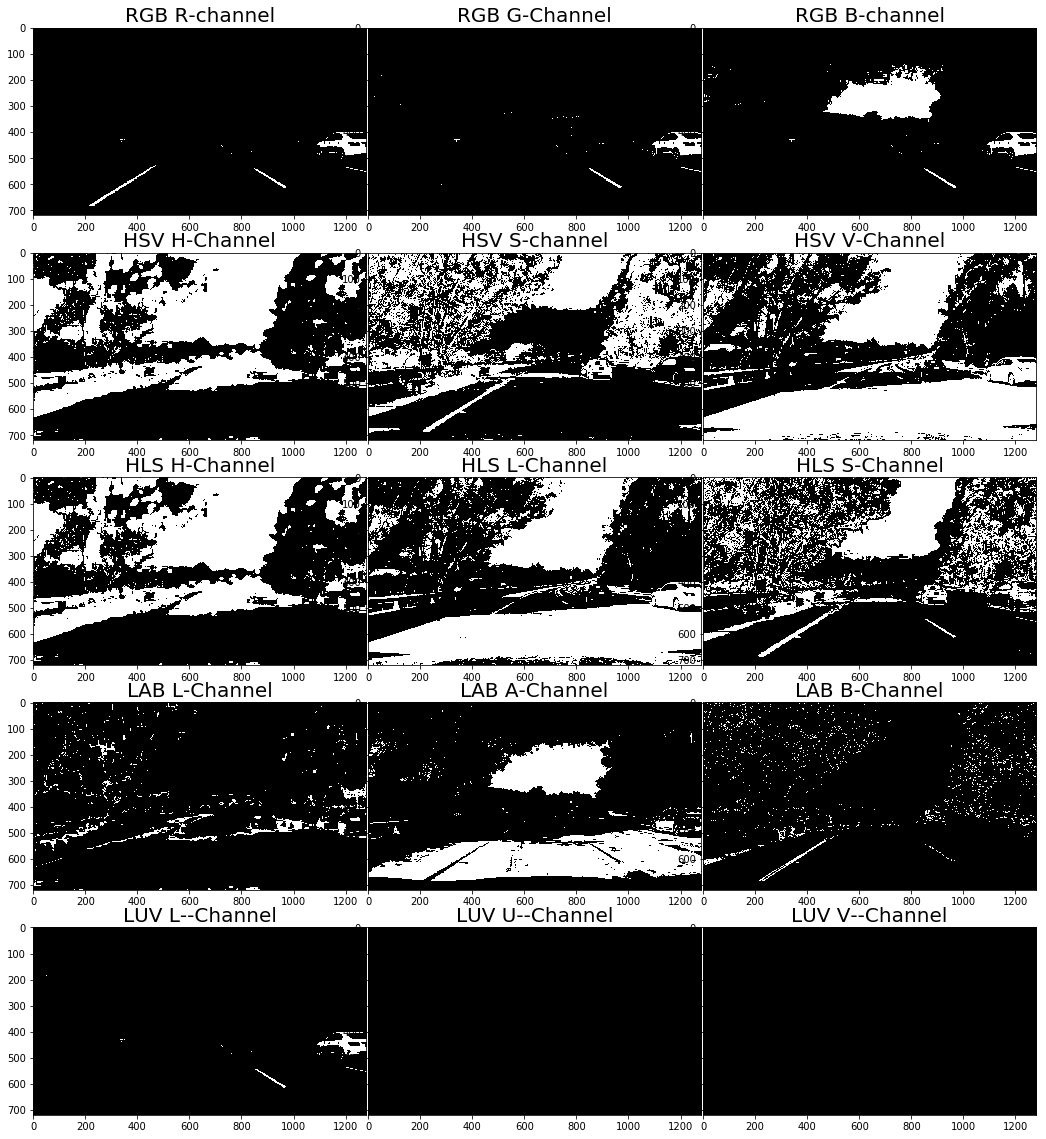

In [13]:
fig, axs = plt.subplots(5,3, figsize=(18, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
sample_R = get_binary(sample_img, conv_type="R", thresh = (220, 255))
sample_G = get_binary(sample_img, conv_type="G", thresh = (200, 255))
sample_B = get_binary(sample_img, conv_type="B", thresh = (200, 255))
sample_H = get_binary(sample_img, conv_type="H", thresh = (90, 255))
sample_S = get_binary(sample_img, conv_type="S", thresh = (90, 255))
sample_V = get_binary(sample_img, conv_type="V", thresh = (90, 255))
sample_HH = get_binary(sample_img, conv_type="HLS_H", thresh = (90, 255))
sample_LL = get_binary(sample_img, conv_type="HLS_L", thresh = (90, 255))
sample_SS = get_binary(sample_img, conv_type="HLS_S", thresh = (90, 255))
sample_LAB_L = get_binary(sample_img, conv_type="LAB_L", thresh = (155, 220))
sample_A = get_binary(sample_img, conv_type="LAB_A", thresh = (155, 220))
sample_LAB_B = get_binary(sample_img, conv_type="LAB_B", thresh = (155, 220))
sample_LUV_L = get_binary(sample_img, conv_type="LUV_L", thresh = (225, 255))
sample_LUV_U = get_binary(sample_img, conv_type="LUV_U", thresh = (225, 255))
sample_LUV_V = get_binary(sample_img, conv_type="LUV_V", thresh = (225, 255))

plot_imgs = [sample_R, sample_G, sample_B, sample_H, sample_S, sample_V, sample_HH, sample_LL, sample_SS,
            sample_LAB_L, sample_A, sample_LAB_B, sample_LUV_L, sample_LUV_U, sample_LUV_V]
titles = ['RGB R-channel', 'RGB G-Channel', 'RGB B-channel', 'HSV H-Channel', 'HSV S-channel', 'HSV V-Channel',
         'HLS H-Channel', 'HLS L-Channel', 'HLS S-Channel', 'LAB L-Channel', 'LAB A-Channel', 'LAB B-Channel',
         'LUV L--Channel', 'LUV U--Channel', 'LUV V--Channel']
for idx, plot_img in zip(range(15),plot_imgs):
    axs[idx].imshow(plot_img, cmap='gray')
    axs[idx].set_title(titles[idx], fontsize=20)

It turned out that R-channel in RGB color space and S-channel in HLS color space have the best performances. However, when I used each one of them as thresholds, the thresholded image always picked up some extra noise caused by the shadows on the road. So I decided to seperate white and yellow lines. More specifically, I used B channel from Lab with thresholds between 155 and 200 for yellow lines and L channel from LUV with thresholds between 225 and 255 for white lines. 

----
<a id='GradientThresholding'></a>
## Gradient Thresholding
[[ go back to the top ]](#Table-of-contents)

<a id='SobelOperator'></a>
### Sobel Operator
[[ go back to the top ]](#Table-of-contents)

In [15]:
# Sobel Operator
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

We'd like to introduce the concept Sobel operator. Applying it to an image is a way of taking the derivative of the image in the x or y direction. See an example below for an image and the output image after applying Sobel x operators to this image. The output image identifies pixels where the gradient of the original image falls within a specified threshold range - 10 to 100.

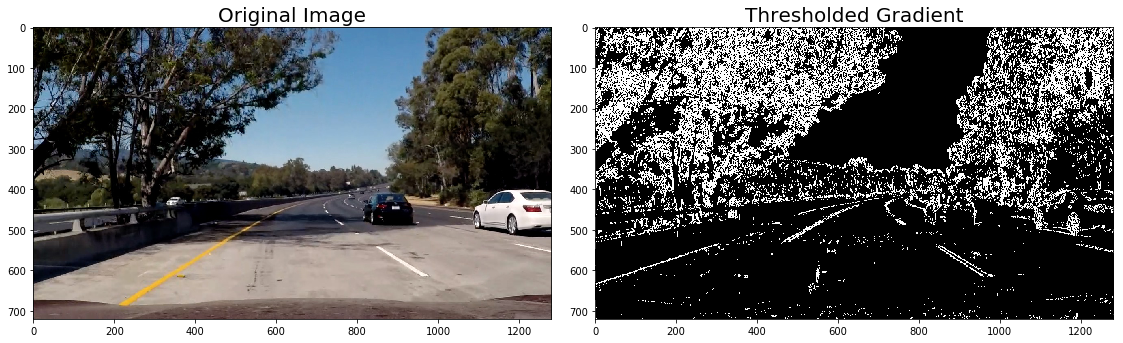

In [16]:
grad_binary = abs_sobel_thresh(sample_img, orient='x', thresh=(10,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

From last exercise, we took the gradient in x and set thresholds to identify pixels within a certain range. We found that it is still hard for us to select lane lines from the images. So our next step is to apply a threshold to the overall magnitude of the gradient, in both x and y. The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients. 

<a id='MagnitudeofGradient'></a>
### Magnitude of Gradient
[[ go back to the top ]](#Table-of-contents)

In [17]:
# magnitude of gradient
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

This example below shows an image and the output image after applying thresholding of magnitude of gradient.

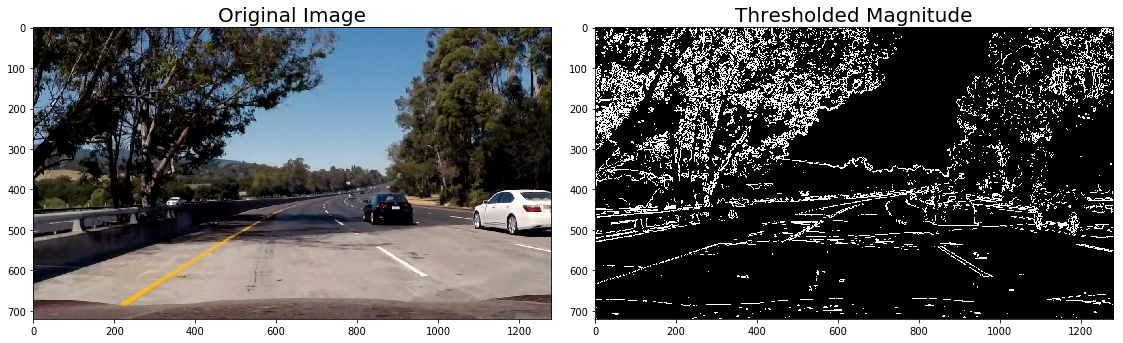

In [18]:
mag_binary = mag_thresh(sample_img, sobel_kernel=3, thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Even though the output image picked up the lane lines, it selected lots of other objects as well. In the case of lane lines, we're interested only in edges of a particular orientation. So now we will explore the direction, or orientation, of the gradient.

<a id='DirectionofGradient'></a>
### Direction of Gradient
[[ go back to the top ]](#Table-of-contents)

In [19]:
# direction of the gradient
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

This example below shows an image and the output image after applying thresholding of direction of gradient. It is clear that the direction of the gradient is much noisier than the gradient magnitude, but we find that we can pick out particular features by orientation.

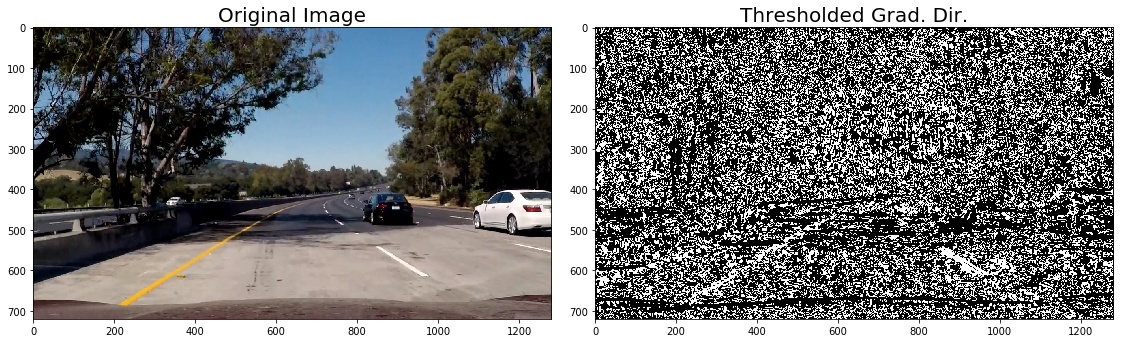

In [20]:
dir_binary = dir_threshold(sample_img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

If we combine various aspects of our gradient measurements - thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines - to isolate lane-line pixels. We can get the output image looks like the one below.

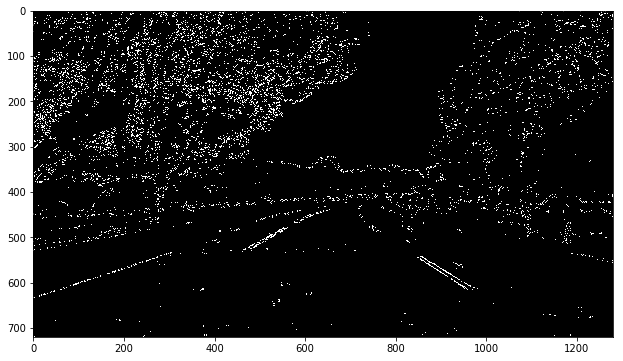

In [21]:
f, ax1 = plt.subplots(1, 1, figsize=(15, 6))
ksize = 3 # Choose a larger odd number to smooth gradient measurements
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(sample_img, orient='x', sobel_kernel=ksize, thresh=(0, 255))
grady = abs_sobel_thresh(sample_img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
mag_binary = mag_thresh(sample_img, sobel_kernel=ksize, thresh=(30, 100))
dir_binary = dir_threshold(sample_img, sobel_kernel=ksize, thresh=(0.7, 1.3))
combined = np.zeros_like(dir_binary)
# both the x and y gradients meet the threshold criteria, or the gradient magnitude 
# and direction are both within their threshold values.
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[ ((mag_binary == 1) & (dir_binary == 1))] = 1
ax1.imshow(combined, cmap='gray')
# plt.imshow(dir_binary, cmap='gray')

----
<a id='ColorandGradient'></a>
## Color and Gradient
[[ go back to the top ]](#Table-of-contents)

We're gonna combine color and gradient thresholding to get the best of both worlds. Let's examine the original image together with the output image with our pipeline. It is clear that we are able to distinguish lane lines from the its surroundings even under shadows!

In [23]:
def thresholding_pipeline(img, b_thresh=(155, 200), l_thresh=(225, 255), sx_thresh=(20, 100)):
    b_binary = get_binary(img, conv_type="LAB_B", thresh = b_thresh)
    l_binary = get_binary(img, conv_type="LUV_L", thresh = l_thresh)
    # Sobel x
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[ (b_binary == 1) | (l_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

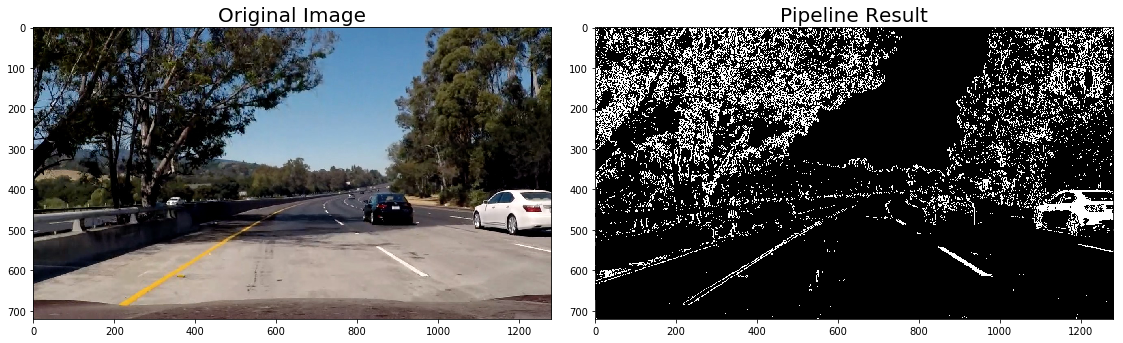

In [24]:
result = thresholding_pipeline(sample_img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [25]:
def thresholding_pipeline(img, s_thresh=(90, 255), sx_thresh=(20, 100)):
    s_binary = get_binary(img, conv_type="HLS_S", thresh = s_thresh)

    # Sobel x
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    # Stack each channel
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

----
<a id='Transform'></a>
## Perspective Transform
[[ go back to the top ]](#Table-of-contents)

Next, we'll demonstrate how we performed a perspective transform on an undistorted image. We are most interested in is a bird’s-eye view transform that let’s us view a lane from above, it will be useful for calculating the lane curvature later on. I created a `lane_unwarp()` function takes as inputs an image (`img`), as well as source (`src`) and destination (`dst`) points. I chose to hardcode the source and destination points.

In [27]:
def lane_unwarp(img, src, dst):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (undist.shape[1], undist.shape[0])
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return undist, warped, M, Minv

In [28]:
h,w = undist_sample.shape[:2]
# define source and destination points for transform
src = np.float32([(610,450),
                  (710,450), 
                  (200,700), 
                  (1100,700)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])
undist, warped, M, Minv = lane_unwarp(sample_img, src, dst)

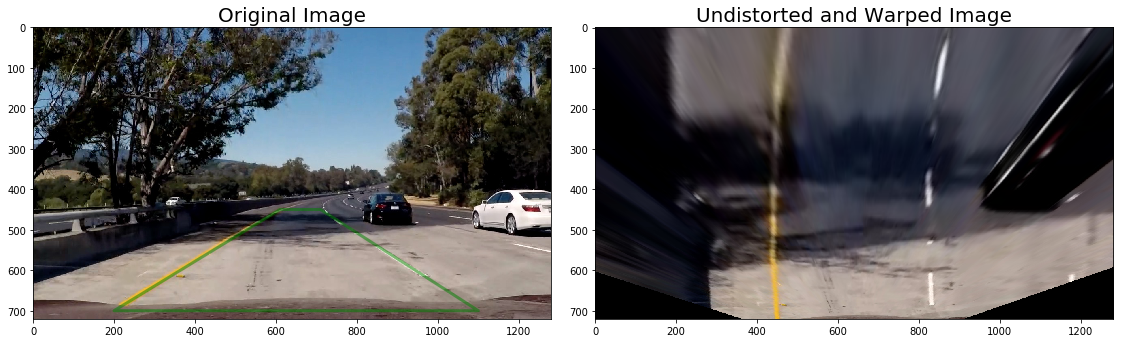

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(sample_img)
ax1.set_title('Original Image', fontsize=20)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='green', alpha=0.5, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

The images above are to verify that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart. Clearly, the lines appear parallel in the warped image.

----
<a id='ThresholdingTransforming'></a>
## Thresholding & Perspective Transforming
[[ go back to the top ]](#Table-of-contents)

We're gonna combine our previous steps - color and gradient thresholding as well as perspective transforming - to process all the test images.

In [30]:
def pipeline(img):
    undist, warped, M, Minv = lane_unwarp(img, src, dst)
    combined_binary = thresholding_pipeline(warped)
    return undist, combined_binary, Minv

In [31]:
images = glob.glob('./test_images/*.jpg')
print("Number of test images: ", len(images))

Number of test images:  8


The following images demonstarte all the test images after applying color thresholding and perspective transform.

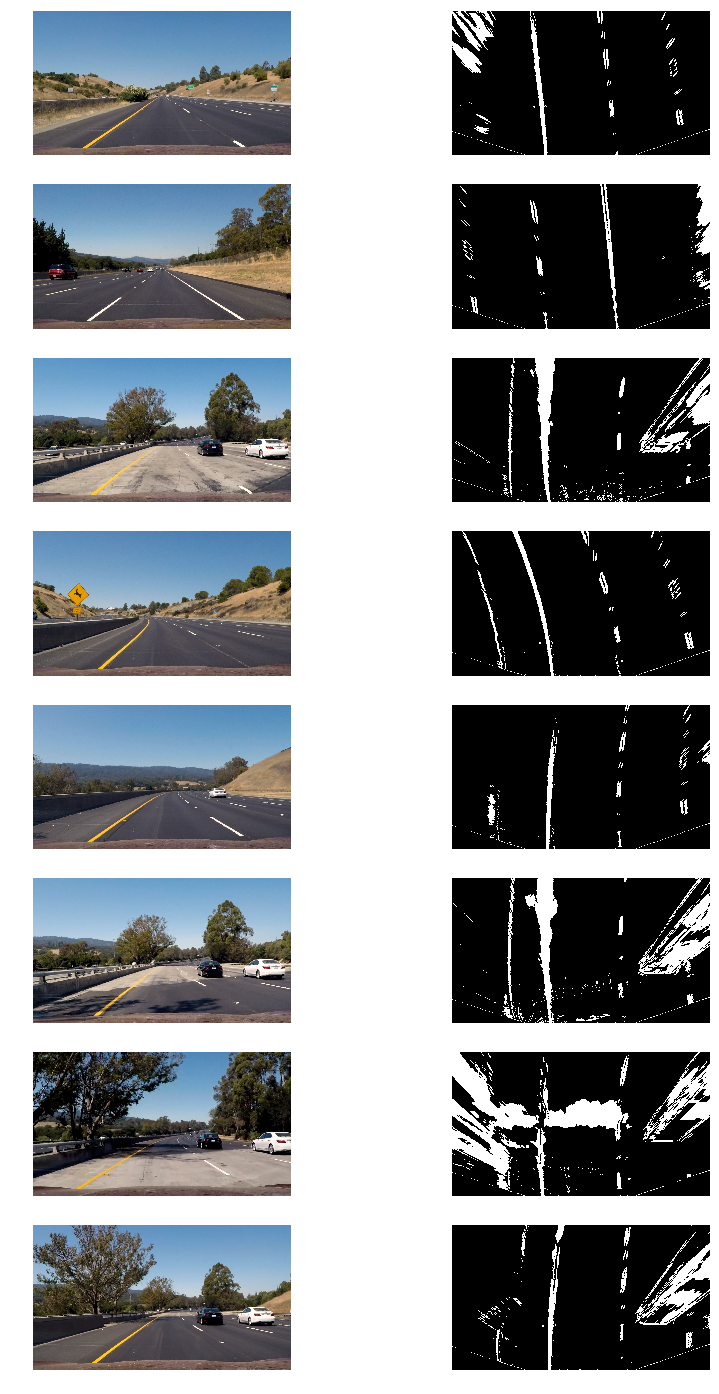

In [32]:
fig, axs = plt.subplots(len(images),2, figsize=(15, 25))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    undist, combined_binary, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(combined_binary, cmap='gray')
    axs[i].axis('off')
    i += 1

----
<a id='CurvedLines'></a>
## Dealing with Curved Lines
[[ go back to the top ]](#Table-of-contents)

After applying calibration, thresholding, and a perspective transform to the original image, we now have a binary image where the lane lines stand out clearly. However, we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line. 

<a id='Histogram'></a>
### Histogram
[[ go back to the top ]](#Table-of-contents)

We looked at the histogram of the image, which is shown below.

In [35]:
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
#     print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, histogram

In [36]:
undist, sample_binary, Minv = pipeline(sample_img)   
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangle_data, histogram = sliding_window_polyfit(sample_binary)

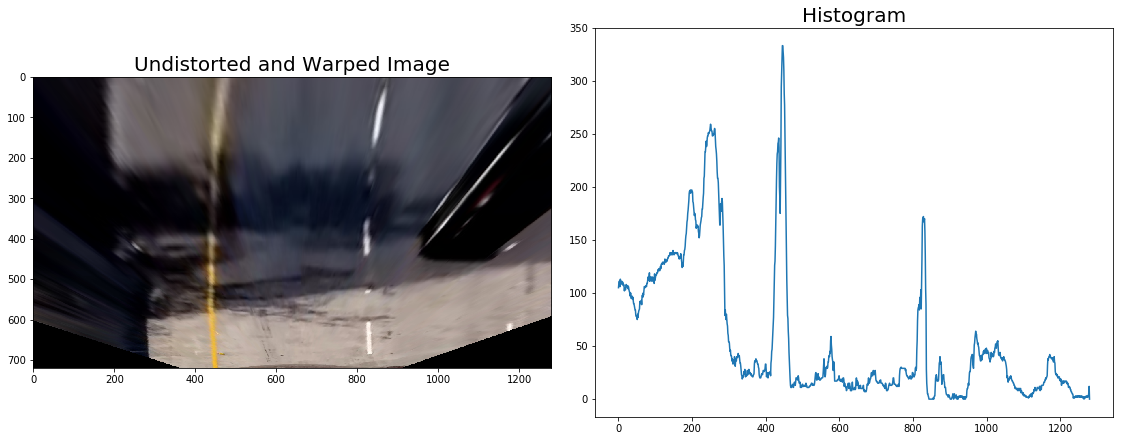

In [38]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Undistorted and Warped Image', fontsize=20)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

<a id='Polynomial'></a>
### Fitting a Polynomial
[[ go back to the top ]](#Table-of-contents)

The two most prominent peaks in the above histogram will be good indicators of the x-position of the base of the lane lines. I can use that as a starting point for where to search for the lines. From that point, I can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.
I used sliding window technique and implemented both `sliding_window_polyfit` and `polyfit_using_prev_fit` to fit my lane lines with a 2nd order polynomial. The following images show the result from `sliding_window_polyfit` and `polyfit_using_prev_fit` respectively.

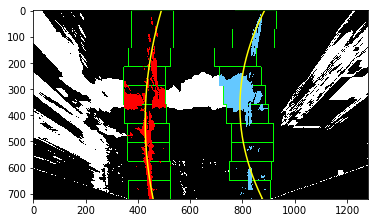

In [39]:
h = sample_img.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((sample_binary, sample_binary, sample_binary))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, sample_binary.shape[0]-1, sample_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangle_data:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = sample_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

In [40]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

In [41]:
left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(sample_binary, left_fit, right_fit)

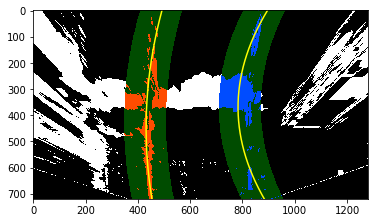

In [42]:
margin = 80
# Generate x and y values for plotting
ploty = np.linspace(0, sample_binary.shape[0]-1, sample_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((sample_binary, sample_binary, sample_binary))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = sample_binary.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')

<a id='curvature'></a>
### Measuring Curvature
[[ go back to the top ]](#Table-of-contents)

Next, we convert x and y from pixels space to meters and calcuate the radius of curvature of the lane and the position of the vehicle with respect to center.

In [43]:
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

In [44]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(sample_binary, left_fit, 
                                                       right_fit, left_lane_inds, right_lane_inds)

In [45]:
print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 138.26434342034545 m, 70.74040942441181 m
Distance from lane center for example: -0.2699443018575982 m


----
<a id='Complete'></a>
## Complete Pipeline
[[ go back to the top ]](#Table-of-contents)

We need to draw lines as well as add text on the image. Putting everthing together, we'll have a comple pipeline of detecting lane lines on the road.

<a id='Draw'></a>
### Draw lines
[[ go back to the top ]](#Table-of-contents)

The image with lane lines drawn is shown below.

In [46]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

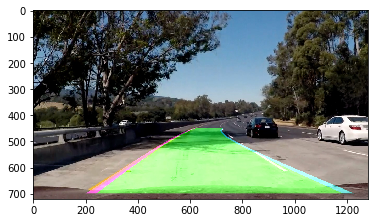

In [47]:
sample_result = draw_lane(sample_img, sample_binary , left_fit, right_fit, Minv)
plt.imshow(sample_result)

<a id='text'></a>
### Add Text
[[ go back to the top ]](#Table-of-contents)

We added the radius of curvature and the position of the vehicle on top of the image.

In [48]:
def put_text(img, rad_l, rad_r, center_dist):
    new_img = np.copy(img)
    h = new_img.shape[0]
#     font = cv2.FONT_HERSHEY_DUPLEX
    curv_rad = (rad_l + rad_r) / float(2)
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, org=(210,70), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, 
                color=(255,255,255), thickness=2, lineType = cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Vehicle is {:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (210,120), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return new_img

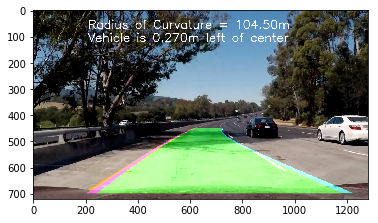

In [49]:
plt.imshow(put_text(sample_result, rad_l, rad_r, d_center))

<a id='Previous'></a>
### Track Previous Detections
[[ go back to the top ]](#Table-of-contents)

In [50]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

In [51]:
def detection_pipeline(img):
    new_img = np.copy(img)
    undist, img_bin, Minv = pipeline(new_img)   
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, rec_, hist_ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
    
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out = draw_lane(undist, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = put_text(img_out, rad_l, rad_r, d_center)
    else:
        img_out = undist
    
    return img_out

Our pipeline perform reasonably well on all the test images. Now we can apply it to the entire video!

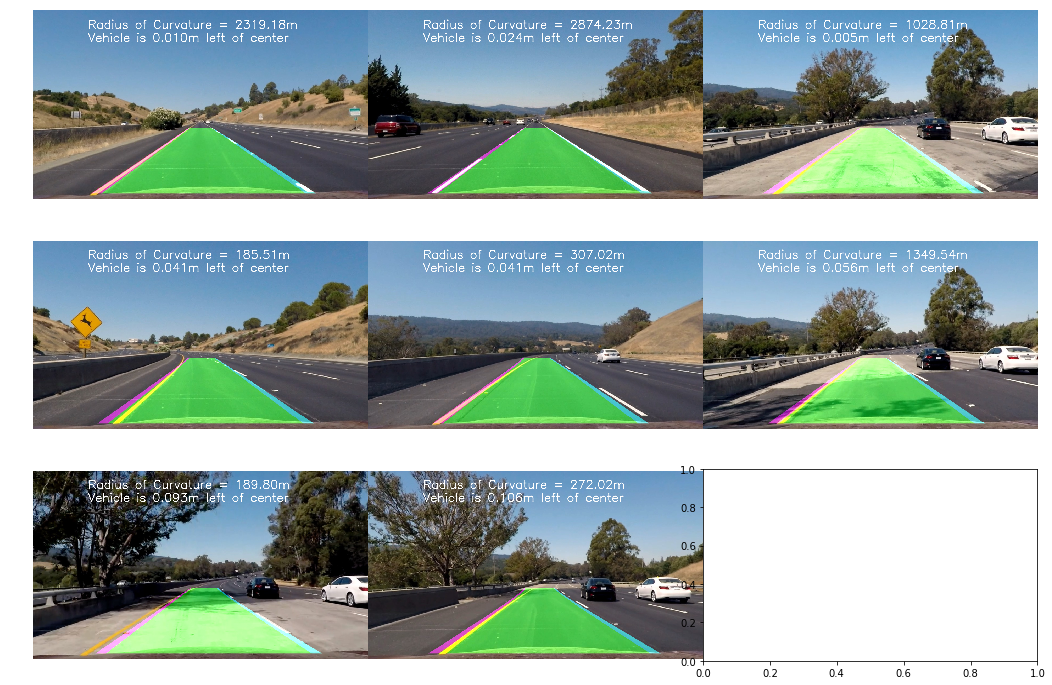

In [53]:
fig, axs = plt.subplots(3,3, figsize=(18, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
l_line = Line()
r_line = Line()
    
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = detection_pipeline(img)
    axs[i].imshow(result)
    axs[i].axis('off')
    i += 1

The results look good.

<a id='Video'></a>
### Process Video
[[ go back to the top ]](#Table-of-contents)

In [54]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [188]:
l_line = Line()
r_line = Line()
# video_input = VideoFileClip('project_video.mp4').subclip(30,50)
video_input = VideoFileClip('project_video.mp4')
video_output = 'project_video_output.mp4'
processed_video = video_input.fl_image(detection_pipeline)
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [02:27<00:00,  8.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 13s, sys: 38.8 s, total: 3min 52s
Wall time: 2min 28s


In [55]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
    "https://github.com/wzding/Self_Driving_Car_Nanodegree/raw/master/Advanced-Lane-Lines/project_video_output.mp4"))

----
<a id='Reflection'></a>
## Reflection
[[ go back to the top ]](#Table-of-contents)

* Problems / issues I faced in the implementation of this project:  

I started with some easy samples and the results of my line detection pipeline worked well untill the vehicle entered a shaded area. Then I worked with the most changllenging image - the one with most shades - in the test images to get a feel of selecting color space and tuning the parameters. I revised my pipeline based on the results of the most changllenging image and it also worked for other images. Some of the detected lane lines are wobbly but the output has an overall precise detection.  

* Where will the pipeline likely fail? What could we do to make it more robust?

My pipeline is likely fail when there are white or light color cars or white signs in front of the vehicle, because then it may consider those kinds of objects as part of the lanes. To make it more robust, possible ways include selecting certain areas in the perspective transformed image to apply color thresholding rather than the whole image. 